# Model Evlauation: Deep Learning Models

## Importing Relevant Libraries

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Flatten, Bidirectional
from tensorflow.keras.layers import TextVectorization, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

## Reading Data

In [ ]:
df = pd.read_csv('Data/processed_new.csv', 
                 usecols=['new_processed', 'Priority'])
df.head(3)

,Priority,new_processed
0,High,claim assign hacker send message login page st...
1,High,log td check old charge able money cash money ...
2,High,hi receive email chime debit card send address...


In [ ]:
df.isnull().sum()

Priority           0
new_processed    359
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df['seq_length'] = df['new_processed'].apply(lambda text: len(text.split()))

In [ ]:
df.head()

,Priority,new_processed,seq_length
0,High,claim assign hacker send message login page st...,165
1,High,log td check old charge able money cash money ...,30
2,High,hi receive email chime debit card send address...,23
3,High,allow fraudulent transaction notify email phon...,104
4,High,payment find scam want help reverse payment tr...,10


In [ ]:
df['seq_length'].describe()

count    51591.000000
mean        79.408928
std         87.440430
min          4.000000
25%         31.000000
50%         56.000000
75%         98.000000
max       2295.000000
Name: seq_length, dtype: float64

In [ ]:
df.shape

(51591, 3)

## Splitting Data into Train, Test, Validation

In [ ]:
X = df['new_processed']

In [ ]:
y = pd.get_dummies(df['Priority']).values

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, 
                                                              random_state=42, 
                                                              stratify=y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=y_train_full)

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((33017,), (10319,), (8255,))

In [ ]:
y_train.shape, y_test.shape, y_val.shape

((33017, 3), (10319, 3), (8255, 3))

In [ ]:
df.loc[df['seq_length'] > 125].shape

(8517, 3)

## Text Vectoization

In [ ]:
seq_length = 100

In [ ]:
vectorize_text = TextVectorization(output_sequence_length=seq_length)
vectorize_text.adapt(X_train)

In [ ]:
vectorize_text.vocabulary_size()

30076

In [ ]:
vocab_size = vectorize_text.vocabulary_size() + 1

## Metric Storage, Plot, and Print

In [ ]:
def plot_learning_curve(model_history):
    history_df = pd.DataFrame(model_history.history)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_df[['loss', 'val_loss']])
    plt.legend(['loss', 'val loss'])
    plt.title('Training Loss vs Validation Loss.', pad=12)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history_df[['accuracy', 'val_accuracy']])
    plt.legend(['Accuracy', 'val accuracy'])
    plt.title('Training Accuracy vs Validation Validation Accuracy.', pad=12)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.tight_layout(w_pad=5)

In [ ]:
metric_info = {'Model_name':[], 
               'Accuracy': [], 
               'Precision': [], 
               'Recall': [], 
               'F1_score': []}

In [ ]:
def store_metrics(metric_list):
    for key, info in zip(metric_info, metric_list):
        metric_info[key].append(info)

In [ ]:
def print_metrics(model, name, test_data=X_test, test_labels=y_test):
    y_pred = to_categorical(np.argmax(model.predict(test_data), axis=1))
    accuracy = np.round(accuracy_score(test_labels, y_pred), 5) * 100
    precision = np.round(precision_score(test_labels, y_pred, average='macro'), 5) * 100
    recall = np.round(recall_score(test_labels, y_pred, average='macro'), 5) * 100
    f1 = np.round(f1_score(test_labels, y_pred, average='macro'), 5) * 100
    #conf_matrix = confusion_matrix(test_labels, y_pred)

    print(f'\nAccuracy score: {accuracy}')
    print(f'\nPrecision score: {precision}')
    print(f'\nRecall score: {recall}')
    print(f'\nF1-Score: {f1}')
    #print(f'\nConfusion Matrix: \n\n{conf_matrix}')

    store_metrics([name, accuracy, precision, recall, f1])

## Modelling

### Simple RNN 

In [ ]:
rnn_model = Sequential()
rnn_model.add(tf.keras.Input(shape=(1,), dtype='string'))

rnn_model.add(vectorize_text)
rnn_model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=seq_length))

rnn_model.add(SimpleRNN(256))

rnn_model.add(Dense(3, activation='softmax'))

rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 100, 300)          9023100   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256)               142592    
                                                                 
 dense_8 (Dense)             (None, 3)                 771       
                                                                 
Total params: 9,166,463
Trainable params: 9,166,463
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
rnn_history = rnn_model.fit(X_train, y_train, batch_size=32, 
                            epochs=100, callbacks=[early_stop], 
                            validation_data=(X_val, y_val))

Epoch 1/100
1032/1032 [==============================] - 103s 98ms/step - loss: 1.0502 - accuracy: 0.4194 - val_loss: 1.0219 - val_accuracy: 0.4430
Epoch 2/100
1032/1032 [==============================] - 101s 98ms/step - loss: 1.0232 - accuracy: 0.4426 - val_loss: 1.0619 - val_accuracy: 0.4397
Epoch 3/100
1032/1032 [==============================] - 101s 98ms/step - loss: 0.9904 - accuracy: 0.4706 - val_loss: 1.0344 - val_accuracy: 0.4356
Epoch 4/100
1032/1032 [==============================] - 101s 98ms/step - loss: 0.9525 - accuracy: 0.4908 - val_loss: 1.0987 - val_accuracy: 0.4355
Epoch 5/100
1032/1032 [==============================] - 101s 97ms/step - loss: 0.9400 - accuracy: 0.5033 - val_loss: 1.0532 - val_accuracy: 0.4213
Epoch 6/100
1032/1032 [==============================] - 104s 100ms/step - loss: 0.9411 - accuracy: 0.5155 - val_loss: 1.0884 - val_accuracy: 0.4500
Epoch 7/100
1032/1032 [==============================] - 102s 99ms/step - loss: 0.9240 - accuracy: 0.5168 - val

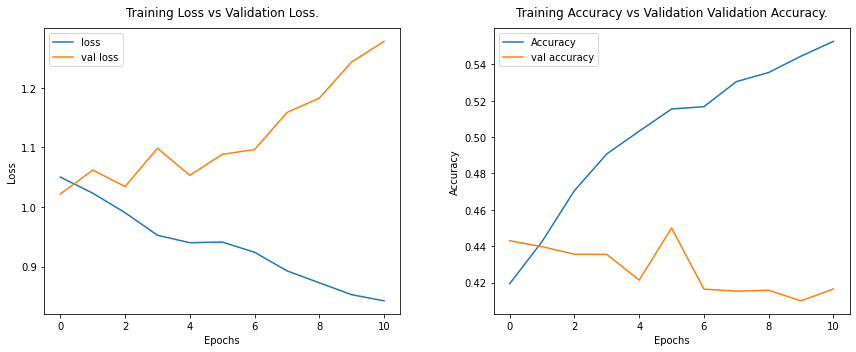

In [ ]:
plot_learning_curve(rnn_history)

In [ ]:
print_metrics(rnn_model, 'RNN-1')

323/323 [==============================] - 6s 17ms/step

Accuracy score: 41.06

Precision score: 33.015

Recall score: 32.741

F1-Score: 29.415999999999997


### LSTM Model 1

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=7)

In [ ]:
lstm_model = Sequential()
lstm_model.add(tf.keras.Input(shape=(1,), dtype='string'))

lstm_model.add(vectorize_text)
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=seq_length))

lstm_model.add(LSTM(128, return_sequences=True, dropout=0.1))
lstm_model.add(LSTM(256, dropout=0.2))
lstm_model.add(Dense(256, activation='relu'))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(3, activation='softmax'))

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 100, 300)          9023100   
                                                                 
 lstm_8 (LSTM)               (None, 100, 128)          219648    
                                                                 
 lstm_9 (LSTM)               (None, 256)               394240    
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=32, 
                                    epochs=100, callbacks=[early_stop], 
                                    validation_data=(X_val, y_val))

Epoch 1/100
1032/1032 [==============================] - 27s 23ms/step - loss: 1.0015 - accuracy: 0.4477 - val_loss: 0.9849 - val_accuracy: 0.4705
Epoch 2/100
1032/1032 [==============================] - 24s 23ms/step - loss: 0.9746 - accuracy: 0.4819 - val_loss: 0.9775 - val_accuracy: 0.4641
Epoch 3/100
1032/1032 [==============================] - 24s 23ms/step - loss: 0.9164 - accuracy: 0.5395 - val_loss: 0.8351 - val_accuracy: 0.6148
Epoch 4/100
1032/1032 [==============================] - 23s 22ms/step - loss: 0.7847 - accuracy: 0.6572 - val_loss: 0.8037 - val_accuracy: 0.6390
Epoch 5/100
1032/1032 [==============================] - 24s 23ms/step - loss: 0.6986 - accuracy: 0.7135 - val_loss: 0.8199 - val_accuracy: 0.6359
Epoch 6/100
1032/1032 [==============================] - 24s 23ms/step - loss: 0.6064 - accuracy: 0.7630 - val_loss: 0.8706 - val_accuracy: 0.6319
Epoch 7/100
1032/1032 [==============================] - 24s 23ms/step - loss: 0.5134 - accuracy: 0.8068 - val_loss: 0

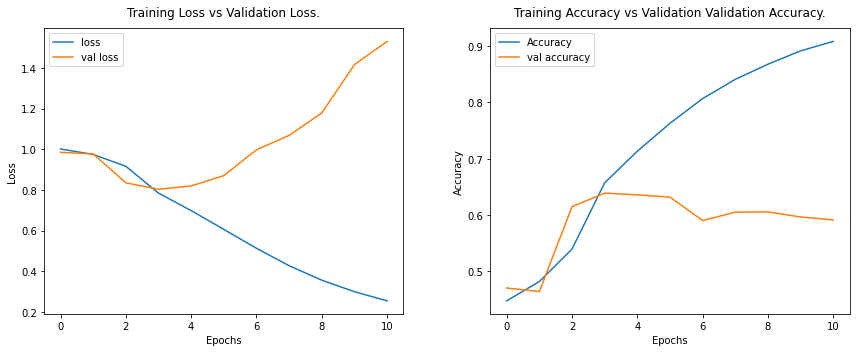

In [ ]:
plot_learning_curve(lstm_model_history)

In [ ]:
print_metrics(lstm_model, 'LSTM-1')

323/323 [==============================] - 3s 8ms/step

Accuracy score: 59.531

Precision score: 57.709999999999994

Recall score: 56.501000000000005

F1-Score: 57.023999999999994


### LSTM Model 2:
- Added more layers
- Added Dense layer after lstm

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
lstm_model_2 = Sequential()
lstm_model_2.add(tf.keras.Input(shape=(1,), dtype='string'))

lstm_model_2.add(vectorize_text)
lstm_model_2.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=seq_length))

lstm_model_2.add(LSTM(256, return_sequences=True, dropout=0.2))
lstm_model_2.add(LSTM(256, return_sequences=True, dropout=0.3))
lstm_model_2.add(LSTM(512, return_sequences=True, dropout=0.3))

lstm_model_2.add(Dense(256, activation='relu'))
lstm_model_2.add(Dropout(0.2))

lstm_model_2.add(Flatten())

lstm_model_2.add(Dense(3, activation='softmax'))

lstm_model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 100, 300)          9023100   
                                                                 
 lstm_10 (LSTM)              (None, 100, 256)          570368    
                                                                 
 lstm_11 (LSTM)              (None, 100, 256)          525312    
                                                                 
 lstm_12 (LSTM)              (None, 100, 512)          1574912   
                                                                 
 dense_11 (Dense)            (None, 100, 256)          131328    
                                                      

In [ ]:
lstm_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
lstm_model_2_history = lstm_model_2.fit(X_train, y_train, 
                                        batch_size=32, epochs=100, 
                                        callbacks=[early_stop], 
                                        validation_data=(X_val, y_val))

Epoch 1/100
1032/1032 [==============================] - 39s 34ms/step - loss: 0.8432 - accuracy: 0.6148 - val_loss: 0.7965 - val_accuracy: 0.6498
Epoch 2/100
1032/1032 [==============================] - 34s 33ms/step - loss: 0.7501 - accuracy: 0.6764 - val_loss: 0.8025 - val_accuracy: 0.6493
Epoch 3/100
1032/1032 [==============================] - 34s 33ms/step - loss: 0.6799 - accuracy: 0.7130 - val_loss: 0.8136 - val_accuracy: 0.6397
Epoch 4/100
1032/1032 [==============================] - 35s 34ms/step - loss: 0.5846 - accuracy: 0.7582 - val_loss: 0.8993 - val_accuracy: 0.6227
Epoch 5/100
1032/1032 [==============================] - 34s 33ms/step - loss: 0.4669 - accuracy: 0.8096 - val_loss: 1.1413 - val_accuracy: 0.6087
Epoch 6/100
1032/1032 [==============================] - 34s 33ms/step - loss: 0.3568 - accuracy: 0.8579 - val_loss: 1.4023 - val_accuracy: 0.5945
Epoch 7/100
1032/1032 [==============================] - 35s 33ms/step - loss: 0.2747 - accuracy: 0.8905 - val_loss: 1

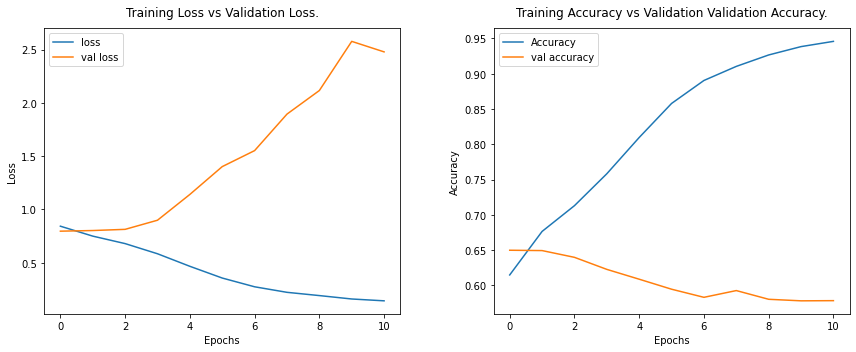

In [ ]:
plot_learning_curve(lstm_model_2_history)

In [ ]:
print_metrics(lstm_model_2, 'LSTM-2')

323/323 [==============================] - 7s 14ms/step

Accuracy score: 59.221000000000004

Precision score: 57.251

Recall score: 56.608999999999995

F1-Score: 56.886


### LSTM with more units

In [ ]:
lstm_3 = Sequential()
lstm_3.add(tf.keras.Input(shape=(1,), dtype='string'))

lstm_3.add(vectorize_text)
lstm_3.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=seq_length))

lstm_3.add(LSTM(512, return_sequences=True, dropout=0.3))
lstm_3.add(LSTM(512, return_sequences=True, dropout=0.3))
lstm_3.add(LSTM(512, return_sequences=True, dropout=0.3))

lstm_3.add(Flatten())

lstm_3.add(Dense(512, activation='relu'))
lstm_3.add(Dropout(0.4))
lstm_3.add(Dense(512, activation='relu'))
lstm_3.add(Dropout(0.5))


lstm_3.add(Dense(3, activation='softmax'))

lstm_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, 100, 300)          9023100   
                                                                 
 lstm_13 (LSTM)              (None, 100, 512)          1665024   
                                                                 
 lstm_14 (LSTM)              (None, 100, 512)          2099200   
                                                                 
 lstm_15 (LSTM)              (None, 100, 512)          2099200   
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                      

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
lstm_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
lstm_3_history = lstm_3.fit(X_train, y_train, 
                                        batch_size=32, epochs=100, 
                                        callbacks=[early_stop], 
                                        validation_data=(X_val, y_val))

Epoch 1/100
1032/1032 [==============================] - 53s 47ms/step - loss: 0.8806 - accuracy: 0.5986 - val_loss: 0.8203 - val_accuracy: 0.6149
Epoch 2/100
1032/1032 [==============================] - 48s 46ms/step - loss: 0.7942 - accuracy: 0.6554 - val_loss: 0.7942 - val_accuracy: 0.6417
Epoch 3/100
1032/1032 [==============================] - 47s 46ms/step - loss: 0.7487 - accuracy: 0.6812 - val_loss: 0.8390 - val_accuracy: 0.6236
Epoch 4/100
1032/1032 [==============================] - 47s 46ms/step - loss: 0.6785 - accuracy: 0.7154 - val_loss: 0.8804 - val_accuracy: 0.6189
Epoch 5/100
1032/1032 [==============================] - 47s 46ms/step - loss: 0.5881 - accuracy: 0.7601 - val_loss: 0.9502 - val_accuracy: 0.6076
Epoch 6/100
1032/1032 [==============================] - 47s 46ms/step - loss: 0.4694 - accuracy: 0.8149 - val_loss: 1.0745 - val_accuracy: 0.5982
Epoch 7/100
1032/1032 [==============================] - 47s 46ms/step - loss: 0.3591 - accuracy: 0.8591 - val_loss: 1

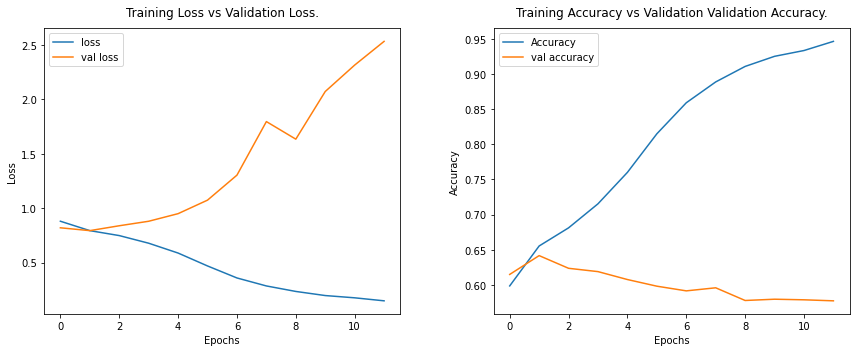

In [ ]:
plot_learning_curve(lstm_3_history)

In [ ]:
print_metrics(lstm_3, 'LSTM-3')

323/323 [==============================] - 6s 15ms/step

Accuracy score: 59.366

Precision score: 57.008

Recall score: 58.239

F1-Score: 57.52


### GRU Model

In [ ]:
gru_1 = Sequential()
gru_1.add(tf.keras.Input(shape=(1,), dtype='string'))

gru_1.add(vectorize_text)
gru_1.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=seq_length))

gru_1.add(GRU(512, return_sequences=True, dropout=0.3))
gru_1.add(GRU(1024, dropout=0.3))

gru_1.add(Dense(3, activation='softmax'))

gru_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, 100, 300)          9023100   
                                                                 
 gru (GRU)                   (None, 100, 512)          1250304   
                                                                 
 gru_1 (GRU)                 (None, 1024)              4724736   
                                                                 
 dense_16 (Dense)            (None, 3)                 3075      
                                                                 
Total params: 15,001,215
Trainable params: 15,001,215
Non-trainable params: 0
__________________________________________

In [ ]:
gru_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
gru_1_history = gru_1.fit(X_train, y_train, 
                                        batch_size=32, epochs=100, 
                                        callbacks=[early_stop], 
                                        validation_data=(X_val, y_val))

Epoch 1/100
1032/1032 [==============================] - 39s 36ms/step - loss: 0.9423 - accuracy: 0.5114 - val_loss: 0.8390 - val_accuracy: 0.6136
Epoch 2/100
1032/1032 [==============================] - 36s 35ms/step - loss: 1.0076 - accuracy: 0.5070 - val_loss: 0.9380 - val_accuracy: 0.5457
Epoch 3/100
1032/1032 [==============================] - 36s 35ms/step - loss: 0.8948 - accuracy: 0.5817 - val_loss: 0.9362 - val_accuracy: 0.5452
Epoch 4/100
1032/1032 [==============================] - 36s 35ms/step - loss: 0.8477 - accuracy: 0.6139 - val_loss: 0.8835 - val_accuracy: 0.5870
Epoch 5/100
1032/1032 [==============================] - 38s 37ms/step - loss: 0.8245 - accuracy: 0.6332 - val_loss: 0.8855 - val_accuracy: 0.6044
Epoch 6/100
1032/1032 [==============================] - 36s 35ms/step - loss: 0.7793 - accuracy: 0.6625 - val_loss: 0.9248 - val_accuracy: 0.6029
Epoch 7/100
1032/1032 [==============================] - 36s 35ms/step - loss: 0.7425 - accuracy: 0.6843 - val_loss: 0

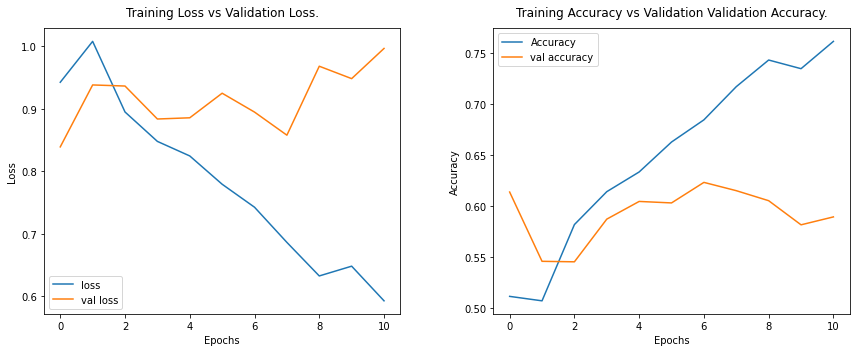

In [ ]:
plot_learning_curve(gru_1_history)

In [ ]:
print_metrics(gru_1, 'GRU-1')

323/323 [==============================] - 4s 11ms/step

Accuracy score: 58.533

Precision score: 55.907

Recall score: 57.635999999999996

F1-Score: 56.467999999999996


### GRU with more units

In [ ]:
gru_2 = Sequential()
gru_2.add(tf.keras.Input(shape=(1,), dtype='string'))

gru_2.add(vectorize_text)
gru_2.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=seq_length))

gru_2.add(GRU(1024, return_sequences=True, dropout=0.3))
gru_2.add(GRU(1024, return_sequences=True, dropout=0.3))
gru_2.add(GRU(2048, dropout=0.3))

gru_2.add(Dense(3, activation='softmax'))

gru_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_9 (Embedding)     (None, 100, 300)          9023100   
                                                                 
 gru_2 (GRU)                 (None, 100, 1024)         4073472   
                                                                 
 gru_3 (GRU)                 (None, 100, 1024)         6297600   
                                                                 
 gru_4 (GRU)                 (None, 2048)              18886656  
                                                                 
 dense_17 (Dense)            (None, 3)                 6147      
                                                      

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=12)

In [ ]:
gru_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
gru_2_history = gru_2.fit(X_train, y_train, 
                                        batch_size=32, epochs=100, 
                                        callbacks=[early_stop], 
                                        validation_data=(X_val, y_val))

Epoch 1/100
1032/1032 [==============================] - 121s 114ms/step - loss: 1.0570 - accuracy: 0.4257 - val_loss: 1.0541 - val_accuracy: 0.4207
Epoch 2/100
1032/1032 [==============================] - 117s 114ms/step - loss: 1.0542 - accuracy: 0.4372 - val_loss: 1.0407 - val_accuracy: 0.4686
Epoch 3/100
1032/1032 [==============================] - 117s 113ms/step - loss: 1.0272 - accuracy: 0.4761 - val_loss: 1.0677 - val_accuracy: 0.4511
Epoch 4/100
1032/1032 [==============================] - 117s 113ms/step - loss: 0.9936 - accuracy: 0.5071 - val_loss: 1.0097 - val_accuracy: 0.4918
Epoch 5/100
1032/1032 [==============================] - 117s 113ms/step - loss: 0.9098 - accuracy: 0.5630 - val_loss: 0.9250 - val_accuracy: 0.5467
Epoch 6/100
1032/1032 [==============================] - 117s 113ms/step - loss: 0.8163 - accuracy: 0.6297 - val_loss: 0.9094 - val_accuracy: 0.5782
Epoch 7/100
1032/1032 [==============================] - 117s 113ms/step - loss: 0.7600 - accuracy: 0.6641

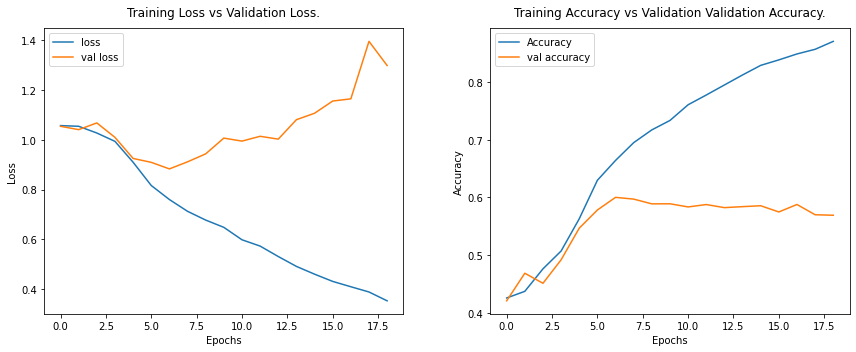

In [ ]:
plot_learning_curve(gru_2_history)

In [ ]:
print_metrics(gru_2, 'GRU-2')

323/323 [==============================] - 13s 36ms/step

Accuracy score: 57.340999999999994

Precision score: 56.16

Recall score: 52.356

F1-Score: 53.40899999999999


### Bi-Directional LSTM

In [ ]:
bi_lstm = Sequential()

bi_lstm.add(tf.keras.Input(shape=(1,), dtype='string'))

bi_lstm.add(vectorize_text)
bi_lstm.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=seq_length))

bi_lstm.add(Bidirectional(LSTM(1024, return_sequences=True, dropout=0.3)))
bi_lstm.add(Bidirectional(LSTM(1024, return_sequences=True, dropout=0.3)))

bi_lstm.add(Dense(1024, activation='relu'))
bi_lstm.add(Dropout(0.4))

bi_lstm.add(Flatten())

bi_lstm.add(Dense(3, activation='softmax'))

bi_lstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_10 (Embedding)    (None, 100, 300)          9023100   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 2048)        10854400  
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 2048)        25174016  
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 100, 1024)         2098176   
                                                     

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=12, mode='min', verbose=1)

In [ ]:
bi_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
bi_lstm_history = bi_lstm.fit(X_train, y_train, 
                                        batch_size=32, epochs=100, 
                                        callbacks=[early_stop], 
                                        validation_data=(X_val, y_val))

Epoch 1/100
1032/1032 [==============================] - 160s 150ms/step - loss: 0.8604 - accuracy: 0.6073 - val_loss: 0.8025 - val_accuracy: 0.6446
Epoch 2/100
1032/1032 [==============================] - 162s 157ms/step - loss: 1.0976 - accuracy: 0.4635 - val_loss: 1.0294 - val_accuracy: 0.4660
Epoch 3/100
1032/1032 [==============================] - 155s 150ms/step - loss: 0.9817 - accuracy: 0.4877 - val_loss: 0.9377 - val_accuracy: 0.5377
Epoch 4/100
1032/1032 [==============================] - 155s 150ms/step - loss: 0.8444 - accuracy: 0.6054 - val_loss: 0.8235 - val_accuracy: 0.6218
Epoch 5/100
1032/1032 [==============================] - 155s 150ms/step - loss: 0.7966 - accuracy: 0.6503 - val_loss: 0.8904 - val_accuracy: 0.5713
Epoch 6/100
1032/1032 [==============================] - 155s 150ms/step - loss: 0.6984 - accuracy: 0.7097 - val_loss: 0.8265 - val_accuracy: 0.6320
Epoch 7/100
1032/1032 [==============================] - 155s 150ms/step - loss: 0.6352 - accuracy: 0.7446

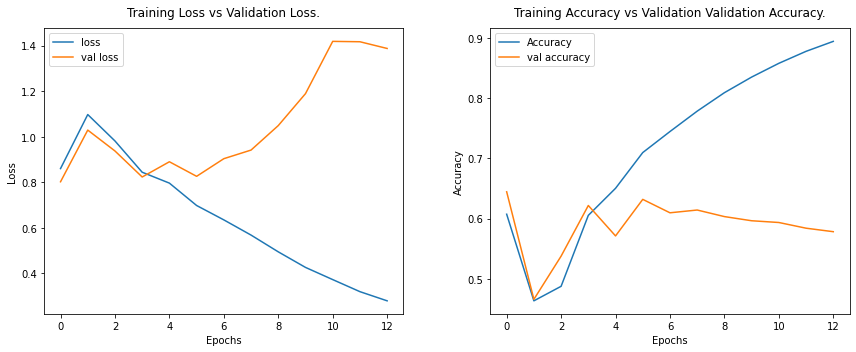

In [ ]:
plot_learning_curve(bi_lstm_history)

In [ ]:
print_metrics(bi_lstm, 'BI-LSTM')

323/323 [==============================] - 19s 52ms/step

Accuracy score: 58.087

Precision score: 55.656000000000006

Recall score: 56.843999999999994

F1-Score: 56.082


## Metrics Comparison of all Models

In [ ]:
metrics_df = pd.DataFrame(metric_info, index=metric_info['Model_name'], columns=list(metric_info.keys())[1:])
metrics_df

,Accuracy,Precision,Recall,F1_score
RNN-1,41.060,33.015,32.741,29.416
LSTM-1,59.531,57.710,56.501,57.024
LSTM-2,59.221,57.251,56.609,56.886
LSTM-3,59.366,57.008,58.239,57.520
GRU-1,58.533,55.907,57.636,56.468
GRU-2,57.341,56.160,52.356,53.409
BI-LSTM,58.087,55.656,56.844,56.082


***************************